In [1]:
from instacart_data import *
from instacart_net import *

import netpixi
from graph_tool import draw
import graph_tool_extras as gte

from graph_tool import centrality, clustering

import regression as reg

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import random as rd

Carregando dados dos produtos...


In [2]:
name = 'edges_teste'

In [3]:
order_products = get_order_products()

Carregando dados dos produtos dos pedidos...


In [4]:
filtered_order_products = { order_id: products for order_id, products in order_products.items() if len(products) <= 5 }
len(order_products), len(filtered_order_products)

(3346083, 1040538)

In [5]:
edges = gen_edges_data(filtered_order_products, name)

Gerando dados das arestas...
Ordenando arestas por peso...
Salvando dados das arestas...


In [6]:
pd.Series(edges.values()).describe().round(2)

count    2272984.00
mean           4.04
std           20.34
min            2.00
25%            2.00
50%            2.00
75%            2.00
max         6188.00
dtype: float64

In [7]:
edges_weights = list(edges.values())
threshold = round(np.mean(edges_weights) + np.std(edges_weights), 0)
threshold

np.float64(24.0)

In [8]:
gen_edges_csv(name, edges, threshold)

35026 arestas geradas com o threshold de 24.0


In [9]:
g = gen_net(name)

In [10]:
layout = draw.sfdp_layout(g)

In [11]:
gte.move(g, layout)

In [12]:
g = gte.clean(g)

In [13]:
c = centrality.closeness(g, harmonic=True)
g.add_vp('closeness', c)
b, _ = centrality.betweenness(g)
g.add_vp('betweenness', b)
d = gte.total_degree(g)
g.add_vp('degree', d)
cc = clustering.local_clustering(g)
g.add_vp('clustering', cc)

In [14]:
gte.save(g, f'{name}.net.gz')

In [15]:
r = netpixi.render(f'{name}.net.gz', infinite=True)

In [16]:
time.sleep(2.5)
r.vertex_default(size=4, bwidth=1)
r.edge_default(width=1)

In [17]:
data = from_net_to_dataframe(g)
data

,id,aisle,department,name,purchased_once,purchased_more_than_once,number_of_users_purchased,total_purchases,PRC,_x,_y,closeness,betweenness,degree,clustering
0,13176,fresh fruits,None,Bag of Organic Bananas,47063,18592,65655,394930,0.283177,4.681532,6.523316,0.710329,0.281221,0.459970,0.016327
1,21137,fresh fruits,None,Organic Strawberries,39871,21258,61129,275577,0.347756,4.665942,6.717096,0.604665,0.052531,0.266285,0.040511
2,6184,packaged produce,None,Clementines,4465,3295,7760,32194,0.424613,5.262456,6.247121,0.494429,0.007588,0.085778,0.163263
3,21903,packaged vegetables fruits,None,Organic Baby Spinach,38095,18671,56766,251705,0.328912,4.713568,6.644791,0.581699,0.035827,0.229985,0.051925
4,16797,fresh fruits,None,Strawberries,25621,19236,44857,149445,0.428829,4.967956,6.585138,0.551544,0.017909,0.174789,0.083221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4018,34991,popcorn jerky,None,Skinny Pack White Cheddar Popcorn,201,252,453,1117,0.556291,5.571654,8.455642,0.305650,0.000000,0.000249,0.000000
4019,30103,cookies cakes,None,"Cookies, Milk Chocolate",50,48,98,252,0.489796,4.012091,8.448462,0.409277,0.000000,0.000249,0.000000
4020,7042,fresh vegetables,None,Rutabagas,50,189,239,352,0.790795,5.887156,4.060700,0.240371,0.000000,0.000249,0.000000
4021,44120,nuts seeds dried fruit,None,Organic Raw Almonds,182,348,530,1085,0.656604,5.363513,5.128749,0.306081,0.000000,0.000249,0.000000


In [18]:
independente = data['clustering']
dependente = data['PRC']
controle = np.log(data['degree'])

data_hipotese = pd.DataFrame({
    'dependente': dependente, 
    'independente': independente, 
    'controle': controle
})

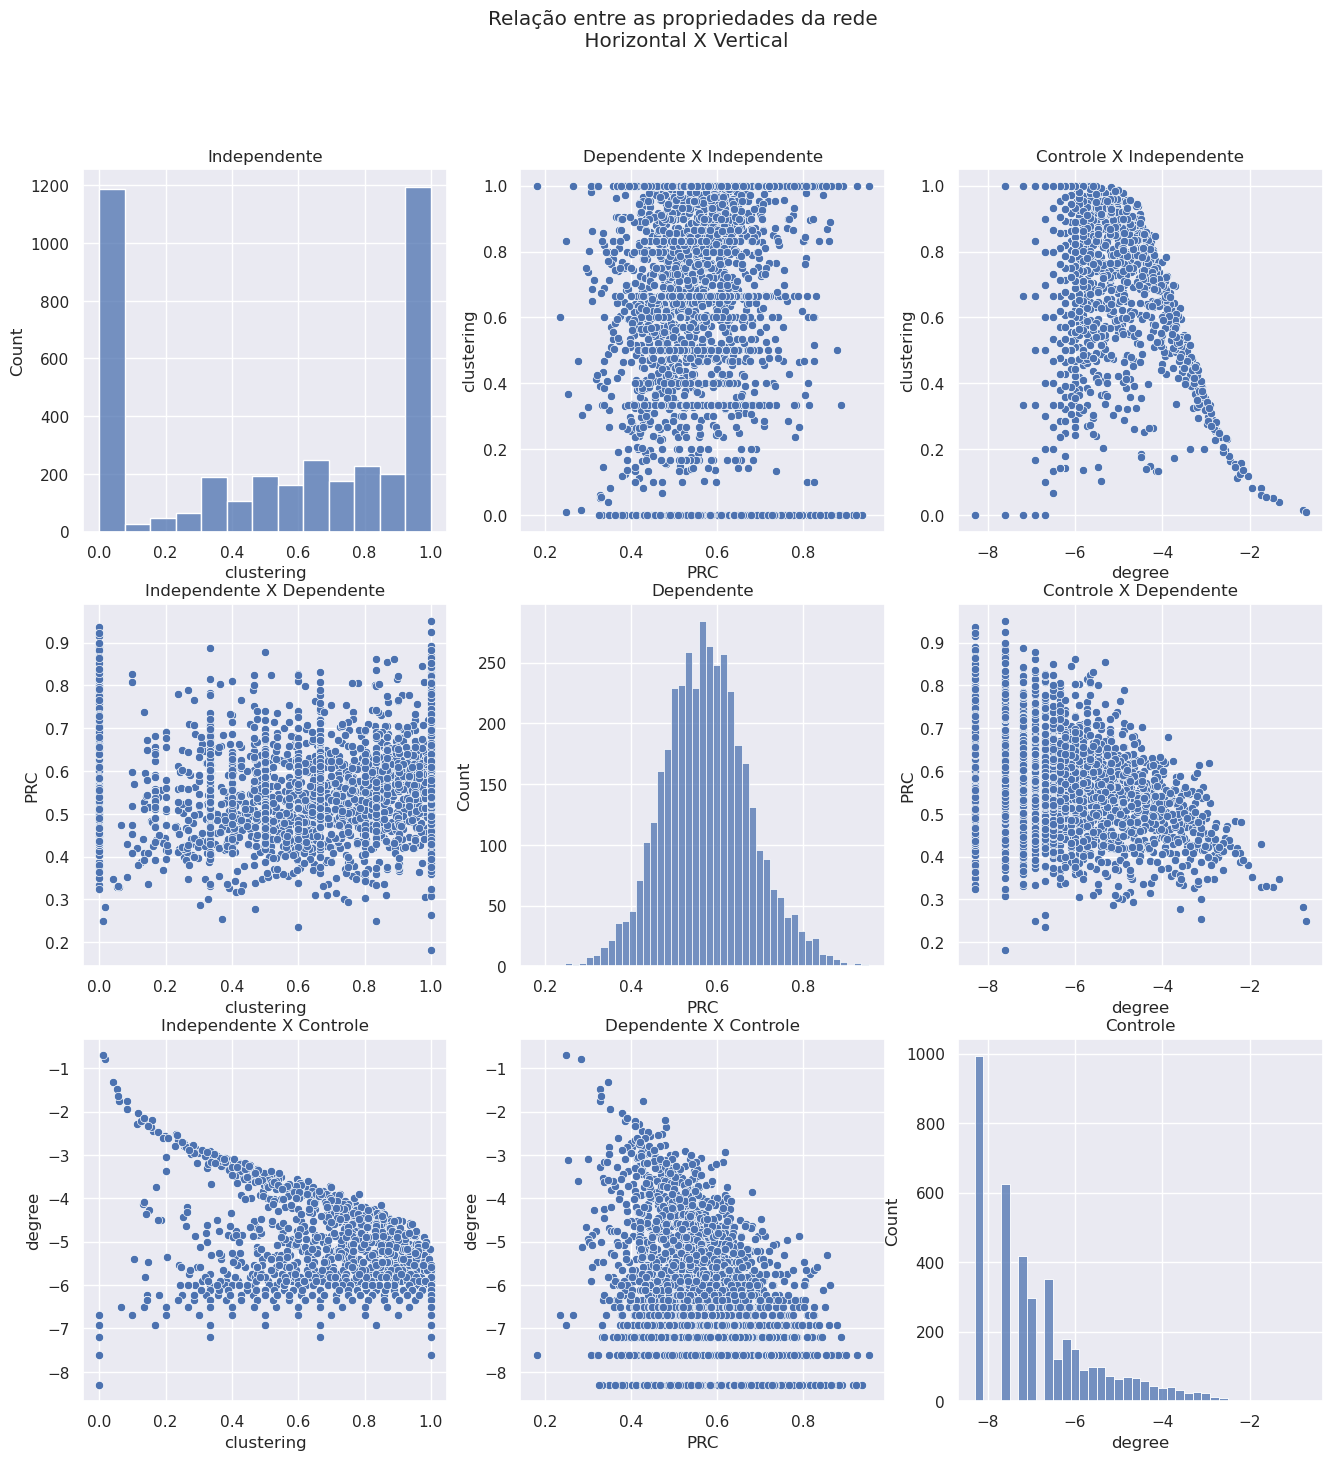

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))

fig.suptitle("Relação entre as propriedades da rede\n Horizontal X Vertical")

sns.histplot(independente, ax=axes[0, 0]).set_title("Independente")
sns.scatterplot(x=dependente, y=independente, ax=axes[0, 1]).set_title("Dependente X Independente")
sns.scatterplot(x=controle, y=independente, ax=axes[0, 2]).set_title("Controle X Independente")

sns.scatterplot(x=independente, y=dependente, ax=axes[1, 0]).set_title("Independente X Dependente")
sns.histplot(dependente, ax=axes[1, 1]).set_title("Dependente")
sns.scatterplot(x=controle, y=dependente, ax=axes[1, 2]).set_title("Controle X Dependente")

sns.scatterplot(x=independente, y=controle, ax=axes[2, 0]).set_title("Independente X Controle")
sns.scatterplot(x=dependente, y=controle, ax=axes[2, 1]).set_title("Dependente X Controle")
sns.histplot(controle, ax=axes[2, 2]).set_title("Controle")

plt.show()

In [20]:
columns = ['independente', 'dependente', 'controle']
pd.DataFrame([[pearsonr(data_hipotese[j], data_hipotese[i]) for j in columns] for i in columns], columns=columns)

,independente,dependente,controle
0,1.0 (óbvio),-0.0562399039 ***,0.3742913582 ***
1,-0.0562399039 ***,1.0 (óbvio),-0.3477476565 ***
2,0.3742913582 ***,-0.3477476565 ***,1.0 (óbvio)


In [21]:
result = reg.linear(data=data_hipotese, formula='dependente ~ independente + controle') # dependente à esquerda!
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             dependente   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     293.2
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          1.43e-119
Time:                        14:20:20   Log-Likelihood:                 3751.3
No. Observations:                4023   AIC:                            -7497.
Df Residuals:                    4020   BIC:                            -7478.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.3746      0.009     41.275      0.000       0.357       0.392
independente     0.0215      0.004      5.410      0.000       0.014       0.029
controle        -0.0279      0.001    -23.911      0.000      -0.030      -0.026
==============================================================================
Omnibus:                       42.736   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.367
Skew:                           0.195   Prob(JB):                     1.91e-11
Kurtosis:                       3.378   Cond. No.                         44.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""